<a href="https://colab.research.google.com/github/xiaochengJF/MachineLearning/blob/master/GBDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GBDT

## 工具
### 基本函数库

In [0]:
from __future__ import division
from itertools import combinations_with_replacement
import numpy as np
import math
import sys


def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]


def batch_iterator(X, y=None, batch_size=64):
    """ Simple batch generator """
    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
        begin, end = i, min(i+batch_size, n_samples)
        if y is not None:
            yield X[begin:end], y[begin:end]
        else:
            yield X[begin:end]


def divide_on_feature(X, feature_i, threshold):
    """ Divide dataset based on if sample value on feature index is larger than
        the given threshold """
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])


def polynomial_features(X, degree):
    n_samples, n_features = np.shape(X)

    def index_combinations():
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        flat_combs = [item for sublist in combs for item in sublist]
        return flat_combs
    
    combinations = index_combinations()
    n_output_features = len(combinations)
    X_new = np.empty((n_samples, n_output_features))
    
    for i, index_combs in enumerate(combinations):  
        X_new[:, i] = np.prod(X[:, index_combs], axis=1)

    return X_new


def get_random_subsets(X, y, n_subsets, replacements=True):
    """ Return random subsets (with replacements) of the data """
    n_samples = np.shape(X)[0]
    # Concatenate x and y and do a random shuffle
    X_y = np.concatenate((X, y.reshape((1, len(y))).T), axis=1)
    np.random.shuffle(X_y)
    subsets = []

    # Uses 50% of training samples without replacements
    subsample_size = int(n_samples // 2)
    if replacements:
        subsample_size = n_samples      # 100% with replacements

    for _ in range(n_subsets):
        idx = np.random.choice(
            range(n_samples),
            size=np.shape(range(subsample_size)),
            replace=replacements)
        X = X_y[idx][:, :-1]
        y = X_y[idx][:, -1]
        subsets.append([X, y])
    return subsets


def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std


def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test


def k_fold_cross_validation_sets(X, y, k, shuffle=True):
    """ Split the data into k sets of training / test data """
    if shuffle:
        X, y = shuffle_data(X, y)

    n_samples = len(y)
    left_overs = {}
    n_left_overs = (n_samples % k)
    if n_left_overs != 0:
        left_overs["X"] = X[-n_left_overs:]
        left_overs["y"] = y[-n_left_overs:]
        X = X[:-n_left_overs]
        y = y[:-n_left_overs]

    X_split = np.split(X, k)
    y_split = np.split(y, k)
    sets = []
    for i in range(k):
        X_test, y_test = X_split[i], y_split[i]
        X_train = np.concatenate(X_split[:i] + X_split[i + 1:], axis=0)
        y_train = np.concatenate(y_split[:i] + y_split[i + 1:], axis=0)
        sets.append([X_train, X_test, y_train, y_test])

    # Add left over samples to last set as training samples
    if n_left_overs != 0:
        np.append(sets[-1][0], left_overs["X"], axis=0)
        np.append(sets[-1][2], left_overs["y"], axis=0)

    return np.array(sets)


def to_categorical(x, n_col=None):
    """ One-hot encoding of nominal values """
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot


def to_nominal(x):
    """ Conversion from one-hot encoding to nominal """
    return np.argmax(x, axis=1)


def make_diagonal(x):
    """ Converts a vector into an diagonal matrix """
    m = np.zeros((len(x), len(x)))
    for i in range(len(m[0])):
        m[i, i] = x[i]
    return m

In [0]:
from __future__ import division
import numpy as np
import math
import sys


def calculate_entropy(y):
    """ Calculate the entropy of label array y """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy


def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse


def calculate_variance(X):
    """ Return the variance of the features in dataset X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance


def calculate_std_dev(X):
    """ Calculate the standard deviations of the features in dataset X """
    std_dev = np.sqrt(calculate_variance(X))
    return std_dev


def euclidean_distance(x1, x2):
    """ Calculates the l2 distance between two vectors """
    distance = 0
    # Squared distance between each coordinate
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return math.sqrt(distance)


def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy


def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)

In [0]:
from __future__ import division
import numpy as np
# from utils import accuracy_score

class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0

class SquareLoss(Loss):
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

class CrossEntropy(Loss):
    def __init__(self): pass

    def loss(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)


class SotfMaxLoss(Loss):
    def gradient(self, y, p):
        return y - p

### 绘图工具

In [0]:
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np


bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()

## 决策树

In [0]:
from __future__ import division, print_function
import numpy as np

#from utils import divide_on_feature, train_test_split, standardize, mean_squared_error
#from utils import calculate_entropy, accuracy_score, calculate_variance


class DecisionNode():
    """Class that represents a decision node or leaf in the decision tree
    Parameters:
    -----------
    feature_i: int
        Feature index which we want to use as the threshold measure.
    threshold: float
        The value that we will compare feature values at feature_i against to
        determine the prediction.
    value: float
        The class prediction if classification tree, or float value if regression tree.
    true_branch: DecisionNode
        Next decision node for samples where features value met the threshold.
    false_branch: DecisionNode
        Next decision node for samples where features value did not meet the threshold.
    """

    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i  # Index for the feature that is tested
        self.threshold = threshold  # Threshold value for feature
        self.value = value  # Value if the node is a leaf in the tree
        self.true_branch = true_branch  # 'Left' subtree
        self.false_branch = false_branch  # 'Right' subtree


# Super class of RegressionTree and ClassificationTree
class DecisionTree(object):
    """Super class of RegressionTree and ClassificationTree.
    Parameters:
    -----------
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_impurity: float
        The minimum impurity required to split the tree further.
    max_depth: int
        The maximum depth of a tree.
    loss: function
        Loss function that is used for Gradient Boosting models to calculate impurity.
    """

    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  # Root node in dec. tree
        # Minimum n of samples to justify split
        self.min_samples_split = min_samples_split
        # The minimum impurity to justify split
        self.min_impurity = min_impurity
        # The maximum depth to grow the tree to
        self.max_depth = max_depth
        # Function to calculate impurity (classif.=>info gain, regr=>variance reduct.)
        # 切割树的方法，gini，方差等
        self._impurity_calculation = None
        # Function to determine prediction of y at leaf
        # 树节点取值的方法，分类树：选取出现最多次数的值，回归树：取所有值的平均值
        self._leaf_value_calculation = None
        # If y is one-hot encoded (multi-dim) or not (one-dim)
        self.one_dim = None
        # If Gradient Boost
        self.loss = loss

    def fit(self, X, y, loss=None):
        """ Build decision tree """
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss = None

    def _build_tree(self, X, y, current_depth=0):
        """ Recursive method which builds out the decision tree and splits X and respective y
        on the feature of X which (based on impurity) best separates the data"""
        largest_impurity = 0
        best_criteria = None  # Feature index and threshold
        best_sets = None  # Subsets of the data

        # Check if expansion of y is needed
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        # Add y as last column of X
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # Calculate the impurity for each feature
            for feature_i in range(n_features):
                # All values of feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                # Iterate through all unique values of feature column i and
                # calculate the impurity
                for threshold in unique_values:
                    # Divide X and y depending on if the feature value of X at index feature_i
                    # meets the threshold
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Select the y-values of the two sets
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # Calculate impurity
                        impurity = self._impurity_calculation(y, y1, y2)

                        # If this threshold resulted in a higher information gain than previously
                        # recorded save the threshold value and the feature
                        # index
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],  # X of left subtree
                                "lefty": Xy1[:, n_features:],  # y of left subtree
                                "rightX": Xy2[:, :n_features],  # X of right subtree
                                "righty": Xy2[:, n_features:]  # y of right subtree
                            }

        if largest_impurity > self.min_impurity:
            # Build subtrees for the right and left branches
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                "threshold"], true_branch=true_branch, false_branch=false_branch)

        # We're at leaf => determine value
        leaf_value = self._leaf_value_calculation(y)
        return DecisionNode(value=leaf_value)

    def predict_value(self, x, tree=None):
        """ Do a recursive search down the tree and make a prediction of the data sample by the
            value of the leaf that we end up at """

        if tree is None:
            tree = self.root

        # If we have a value (i.e we're at a leaf) => return value as the prediction
        if tree.value is not None:
            return tree.value

        # Choose the feature that we will test
        feature_value = x[tree.feature_i]

        # Determine if we will follow left or right branch
        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        # Test subtree
        return self.predict_value(x, branch)

    def predict(self, X):
        """ Classify samples one by one and return the set of labels """
        y_pred = []
        for x in X:
            y_pred.append(self.predict_value(x))
        return y_pred

    def print_tree(self, tree=None, indent=" "):
        """ Recursively print the decision tree """
        if not tree:
            tree = self.root

        # If we're at leaf => print the label
        if tree.value is not None:
            print(tree.value)
        # Go deeper down the tree
        else:
            # Print test
            print("%s:%s? " % (tree.feature_i, tree.threshold))
            # Print the true scenario
            print("%sT->" % (indent), end="")
            self.print_tree(tree.true_branch, indent + indent)
            # Print the false scenario
            print("%sF->" % (indent), end="")
            self.print_tree(tree.false_branch, indent + indent)


class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, y1, y2):
        # Calculate information gain
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * \
                              calculate_entropy(y1) - (1 - p) * \
                                                      calculate_entropy(y2)
        # print("info_gain",info_gain)
        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Count number of occurences of samples with label
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        # print("most_common :",most_common)
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_information_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)


class RegressionTree(DecisionTree):
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        # Calculate the variance reduction
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)

        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)


class XGBoostRegressionTree(DecisionTree):
    """
    Regression tree for XGBoost
    - Reference -
    http://xgboost.readthedocs.io/en/latest/model.html
    """

    def _split(self, y):
        """ y contains y_true in left half of the middle column and
        y_pred in the right half. Split and return the two matrices """
        col = int(np.shape(y)[1] / 2)
        y, y_pred = y[:, :col], y[:, col:]
        return y, y_pred

    def _gain(self, y, y_pred):
        nominator = np.power((y * self.loss.gradient(y, y_pred)).sum(), 2)
        denominator = self.loss.hess(y, y_pred).sum()
        return 0.5 * (nominator / denominator)

    def _gain_by_taylor(self, y, y1, y2):
        # Split
        y, y_pred = self._split(y)
        y1, y1_pred = self._split(y1)
        y2, y2_pred = self._split(y2)

        true_gain = self._gain(y1, y1_pred)
        false_gain = self._gain(y2, y2_pred)
        gain = self._gain(y, y_pred)
        return true_gain + false_gain - gain

    def _approximate_update(self, y):
        # y split into y, y_pred
        y, y_pred = self._split(y)
        # Newton's Method
        gradient = np.sum(y * self.loss.gradient(y, y_pred), axis=0)
        hessian = np.sum(self.loss.hess(y, y_pred), axis=0)
        update_approximation = gradient / hessian

        return update_approximation

    def fit(self, X, y):
        self._impurity_calculation = self._gain_by_taylor
        self._leaf_value_calculation = self._approximate_update
        super(XGBoostRegressionTree, self).fit(X, y)

## GBDT

In [0]:
from __future__ import division, print_function
import numpy as np
import progressbar

# Import helper functions
#from utils import train_test_split, standardize, to_categorical
#from utils import mean_squared_error, accuracy_score
#from utils.loss_functions import SquareLoss, CrossEntropy, SotfMaxLoss
#from decision_tree.decision_tree_model import RegressionTree
#from utils.misc import bar_widgets


class GBDT(object):
    """Super class of GradientBoostingClassifier and GradientBoostinRegressor.
    Uses a collection of regression trees that trains on predicting the gradient
    of the loss function.
    Parameters:
    -----------
    n_estimators: int
        树的数量
        The number of classification trees that are used.
    learning_rate: float
        梯度下降的学习率
        The step length that will be taken when following the negative gradient during
        training.
    min_samples_split: int
        每棵子树的节点的最小数目（小于后不继续切割）
        The minimum number of samples needed to make a split when building a tree.
    min_impurity: float
        每颗子树的最小纯度（小于后不继续切割）
        The minimum impurity required to split the tree further.
    max_depth: int
        每颗子树的最大层数（大于后不继续切割）
        The maximum depth of a tree.
    regression: boolean
        是否为回归问题
        True or false depending on if we're doing regression or classification.
    """

    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):

        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.regression = regression

        # 进度条 processbar
        self.bar = progressbar.ProgressBar(widgets=bar_widgets)

        self.loss = SquareLoss()
        if not self.regression:
            self.loss = SotfMaxLoss()

        # 分类问题也使用回归树，利用残差去学习概率
        self.trees = []
        for i in range(self.n_estimators):
            self.trees.append(RegressionTree(min_samples_split=self.min_samples_split,
                                             min_impurity=self.min_impurity,
                                             max_depth=self.max_depth))

    def fit(self, X, y):
        # 让第一棵树去拟合模型
        self.trees[0].fit(X, y)
        y_pred = self.trees[0].predict(X)
        for i in self.bar(range(1, self.n_estimators)):
            gradient = self.loss.gradient(y, y_pred)
            self.trees[i].fit(X, gradient)
            y_pred -= np.multiply(self.learning_rate, self.trees[i].predict(X))

    def predict(self, X):
        y_pred = self.trees[0].predict(X)
        for i in range(1, self.n_estimators):
            y_pred -= np.multiply(self.learning_rate, self.trees[i].predict(X))

        if not self.regression:
            # Turn into probability distribution
            y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
            # Set label to the value that maximizes probability
            y_pred = np.argmax(y_pred, axis=1)
        return y_pred


class GBDTRegressor(GBDT):
    def __init__(self, n_estimators=200, learning_rate=0.5, min_samples_split=2,
                 min_var_red=1e-7, max_depth=4, debug=False):
        super(GBDTRegressor, self).__init__(n_estimators=n_estimators,
                                            learning_rate=learning_rate,
                                            min_samples_split=min_samples_split,
                                            min_impurity=min_var_red,
                                            max_depth=max_depth,
                                            regression=True)


class GBDTClassifier(GBDT):
    def __init__(self, n_estimators=200, learning_rate=.5, min_samples_split=2,
                 min_info_gain=1e-7, max_depth=2, debug=False):
        super(GBDTClassifier, self).__init__(n_estimators=n_estimators,
                                             learning_rate=learning_rate,
                                             min_samples_split=min_samples_split,
                                             min_impurity=min_info_gain,
                                             max_depth=max_depth,
                                             regression=False)

    def fit(self, X, y):
        y = to_categorical(y)
        super(GBDTClassifier, self).fit(X, y)


## 测试

In [0]:
#!wget https://github.com/xiaochengJF/Machine-Learning-From-Scratch/blob/master/TempLinkoping2016.txt

In [8]:
cd /content/drive/My Drive/MachineLearning/MLCode/Projects/Machine-Learning-From-Scratch/gradient_boosting_decision_tree

/content/drive/My Drive/MachineLearning/MLCode/Projects/Machine-Learning-From-Scratch/gradient_boosting_decision_tree


-- Gradient Boosting Regression --


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
Training: 100% [-----------------------------------------------] Time:  0:00:25


Mean Squared Error: 10.49341738752049


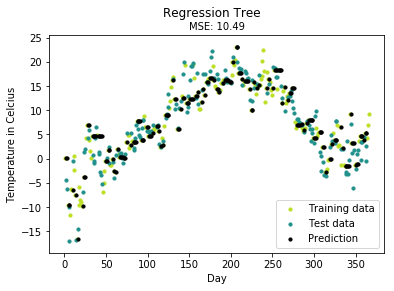

In [9]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar

#from utils import train_test_split, standardize, to_categorical
#from utils import mean_squared_error, accuracy_score, Plot
#from utils.misc import bar_widgets
#from gradient_boosting_decision_tree.gbdt_model import GBDTRegressor


def main():
    print ("-- Gradient Boosting Regression --")

    # Load temperature data
    data = pd.read_csv('../TempLinkoping2016.txt', sep="\t")
    #data = pd.read_csv('TempLinkoping2016.txt', sep="\t")

    time = np.atleast_2d(data["time"].as_matrix()).T
    temp = np.atleast_2d(data["temp"].as_matrix()).T

    X = time.reshape((-1, 1))               # Time. Fraction of the year [0, 1]
    X = np.insert(X, 0, values=1, axis=1)   # Insert bias term
    y = temp[:, 0]                          # Temperature. Reduce to one-dim

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    model = GBDTRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred_line = model.predict(X)

    # Color map
    cmap = plt.get_cmap('viridis')

    mse = mean_squared_error(y_test, y_pred)

    print ("Mean Squared Error:", mse)

    # Plot the results
    m1 = plt.scatter(366 * X_train[:, 1], y_train, color=cmap(0.9), s=10)
    m2 = plt.scatter(366 * X_test[:, 1], y_test, color=cmap(0.5), s=10)
    m3 = plt.scatter(366 * X_test[:, 1], y_pred, color='black', s=10)
    plt.suptitle("Regression Tree")
    plt.title("MSE: %.2f" % mse, fontsize=10)
    plt.xlabel('Day')
    plt.ylabel('Temperature in Celcius')
    plt.legend((m1, m2, m3), ("Training data", "Test data", "Prediction"), loc='lower right')
    plt.show()


if __name__ == "__main__":
    main()